In [1]:
import json
import nltk
import itertools
import argparse
from klm.query import slor, LM, get_unigram_probs
from collections import defaultdict
from nltk.tree import Tree

with open("gists/minidogs.jsonl", "r") as inf:
    lns = [json.loads(i) for i in inf]
    
from environments.envs import ENVIRONMENTS

env = ENVIRONMENTS["DEV"]
LOC = env['klm_model']
UG_MODEL = env["ug_model"]

lm = LM(loc=LOC)
up = get_unigram_probs(UG_MODEL)

ROOT = 'ROOT'


def get_all_combos_of_constituents(jdoc, max_c=100, p=.75):
    '''
    If you assume that the linguistic units are constituents and assume that you want to fill at least 
    p percent of your budget and that you want no more than K elllipses... this is actually combinatorily
    tractable FOR A SINGLE SENTENCE
    
    You just want all nCk combos of constituents, for 1 .... K + 1.
    
    - Then you exclude all of the combos w len more than b and less than p * b
    - You also exclude cases where one unit is nested in the other. You can exclued these safely I think b/c
      if there is a set (x1, x2... xn) s.t xi \in xj then there will be 
      another set (x1, x2... xn) that includes all but xi that makes better use of the xi position
    '''
 
    out = list()
    tree2 = Tree.fromstring(jdoc["parse"])
    getNodes(tree2, out)

    tm = [p[1] for p in out]

    co = 0
    opts = list()
    def has_overlap(tm):
        for a,b in itertools.combinations(tm, r=2):
            if a in b or b in a:
                return True
        return False

    for i in range(1,4):
        for v in itertools.combinations(tm, r=i):
            co += 1
            if sum([len(i) for i in v]) < max_c and sum([len(i) for i in v]) > (p * max_c):
                if not has_overlap(v):
                    opts.append(list(v))
    return opts


def combo2snippet(jdoc,combos):
    sent = " ".join([o["word"] for o in jdoc["tokens"]])
    combos.sort(key=lambda x:sent.index(x))
    return("...".join([c for c in combos]))


def getNodes(parent, out):
    for node in parent:
        if type(node) is nltk.Tree:
            if node.label() == ROOT:
                print("======== Sentence =========")
                print("Sentence:", " ".join(node.leaves()))
            else:
                if len(node.leaves()) > 1:
                    out.append((node.label(), " ".join(node.leaves())))

            getNodes(node, out)
        else:
            pass
        

def find_ngrams(input_list, n):
    return zip(*[input_list[i:] for i in range(n)])


def insert_all_ellipses(toks, start_index, end_index):
    '''
    
    here is another thing that does not really work. 
    
    assume you have  sequence of tokens. Now you want to insert an elipse somewhere. This returns all of the 
    places where you can get an ellipse. 
    
    This is quadratic b/c you loop over start and ends of elipses. This cuts
    down on the search complexity of compressive summarization problem
    
    If you made K recursive calls to add more ellipses, I bet you'd find that high ranking cases mapped to constituents, kind of.
    
    This is something we could use to justify the constituent assumption tho
    
    More details: 

    start_index(int): where to start looping, to insert ellipse
    end_index(int): where to end looping, to insert ellipse
         - If you are looping over the whole sentences then 
             - start_index = 0 and end_index = len(toks)
         - But also you might loop over the last 5 tokens in the sentence
    
    Returns a list of tuples. 
        - The first item in the tuple is the tokens included 
        - The second item in the tuple is the start of ellipse
        - The third item in the tuple is the end of ellipse
    '''
    for start_ellipse in range(start_index, end_index):
        for end_ellipse in range(start_ellipse + 1, end_index):
            yield(start_ellipse, end_ellipse)

### Does SLOR do a good job finding well-formed ngrams? 
No. Sort of disappointed. I guess the coarse ranking is good but fine-grained is not

In [2]:
index = 26
all_ = []
for o in find_ngrams([o["word"] for o in lns[index]['tokens']], n=6):
    str_ = " ".join(o)
    all_.append((str_, max(slor(str_,lm, up), 0)))
    
all_.sort(key=lambda x:x[1], reverse=True)

for o in all_:
    print(o)

('thirty min walks a day .', 0.9980161390218095)
('My little couch potato dog needs', 0.6113157377929687)
('3 thirty min walks a day', 0.4164939557576499)
('little couch potato dog needs 3', 0.3197258045450842)
('couch potato dog needs 3 thirty', 0.031799057637532734)
('potato dog needs 3 thirty min', 0.03132666356608086)
('dog needs 3 thirty min walks', 0)
('needs 3 thirty min walks a', 0)


### Does SLOR do a good job finding well-formed constituents? 
- No. Sort of disappointed. The coarse ranking is good but not the fine-grained ranking, basically. This fits w/ Lau Clarke Lapin who found an approximate correlation

In [3]:
out = []
opts = []
K = 20
sno = 26
tree2 = Tree.fromstring(lns[sno]["parse"])
getNodes(tree2, out)
for o in out:
    label, frag = o
    if len(frag.split()) < K:
        opts.append((frag, slor(frag,lm, up)))

opts = list(set(opts))
opts.sort(key=lambda x:x[1],reverse=True)

print(" ".join([o["word"] for o in lns[sno]["tokens"]]))
for o in opts:
    print(o)

My little couch potato dog needs 3 thirty min walks a day .
('My little couch potato dog needs 3 thirty min walks a day .', 0.8180272019343447)
('My little couch potato dog needs 3 thirty min', 0.7242806523708762)
('My little couch potato dog', 0.6557964061962892)
('walks a day', 0.09627045926513667)
('3 thirty min', 0.08536011938476544)
('a day', -0.09840599101257297)
('needs 3 thirty min', -0.1275434680114751)
('3 thirty', -1.6068268827514647)


### A method that works

Assume you want only a few ellipses (2/3) per sentence. Assume you want to fill your summary budget up to 75%. You can really just enumerate all combos of constituents of size 1,2,3,4, and filter out those that are too long and too short. This is because the number of ellipses will in general be size of combo + 1. There are a manageable number of subsets to just check. If we rank the resullting snippets by SLOR, imagining that the ... are not present, well everything seems to work

In [4]:


sno = 3
combos = get_all_combos_of_constituents(lns[sno], p=.5)

ranks = []

for c in combos:
    snip = combo2snippet(lns[sno], c)
    
    ranks.append((snip, slor(snip.replace("...", " ").replace("  ", " "),lm, up)))
    
ranks.sort(key=lambda x:x[1], reverse=True)

print("top 10 snippets, by SLOR")
for r in ranks[0:10]:
    print(r)
print("\n")
print("bottom 10 snippets, by SLOR")
for r in ranks[-10:]:
    print(r)

top 10 snippets, by SLOR
('I could see myself re-locating to Toronto or Quebec .', 0.8696897867602538)


bottom 10 snippets, by SLOR
('I could see myself re-locating to Toronto or Quebec .', 0.8696897867602538)


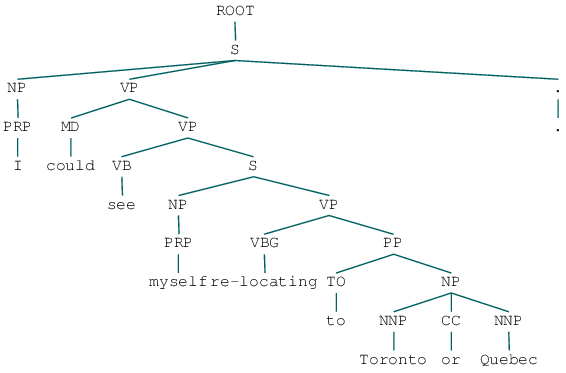

In [5]:
tree2 = Tree.fromstring(lns[sno]["parse"])
tree2

### One note

if you insert ellipses w/o respecting constituents. The SLOR ranking seems ok-ish to evaluate different summaries of
the same size

In [6]:
from environments.envs import ENVIRONMENTS
from collections import defaultdict
import argparse
import kenlm
import json

from klm.query import LM
from klm.query import get_unigram_probs

env = ENVIRONMENTS["DEV"]
LOC = env['klm_model']
UG_MODEL = env["ug_model"]

lm = LM(loc=LOC)
up = get_unigram_probs(UG_MODEL)
from klm.query import slor


toks = "my little couch potato needs 3 thirty minute walks".split()

opts = []

classes = defaultdict(list)

for i in insert_all_ellipses(toks, start_index=0, end_index=len(toks) + 1):
    ellipse_min, ellipse_max = i
    printthis = ""
    for tno, t in enumerate(toks):
        if tno == ellipse_min:
            printthis = printthis + " ... "
        elif tno > ellipse_min and tno < ellipse_max:
            pass
        else:
            printthis = printthis + " " + t
    str_ = printthis.replace(" ... ", " ").strip().replace("  ", " ")
    classes[len(str_.split())].append((printthis, slor(str_,lm, up)))
    
for c in classes:
    print(c)
    opts = classes[c]
    opts.sort(key=lambda x:x[1], reverse=True)
    opts[0:20]
    for o in opts:
        print(o)

8
(' my little couch potato needs 3 thirty minute ... ', 0.6129066852813718)
(' my little couch potato ...  3 thirty minute walks', 0.5386765264556885)
(' my little couch potato needs ...  thirty minute walks', 0.5155214225158691)
(' my little couch potato needs 3 ...  minute walks', 0.3912193690338137)
(' my ...  couch potato needs 3 thirty minute walks', 0.3645562493133543)
(' my little couch potato needs 3 thirty ...  walks', 0.3547105074310304)
(' my little couch ...  needs 3 thirty minute walks', 0.3040491313323983)
(' ...  little couch potato needs 3 thirty minute walks', 0.30112789797973605)
(' my little ...  potato needs 3 thirty minute walks', 0.19168549163208048)
7
(' my little couch potato ...  thirty minute walks', 0.6974210636648996)
(' my little couch potato needs 3 ...  walks', 0.5883220816476005)
(' my little couch potato needs 3 thirty ... ', 0.37479685377022876)
(' my little couch potato needs ...  minute walks', 0.308935251831055)
(' ...  couch potato needs 3 thirty 

In [10]:
import os, os.path
from whoosh import index

from whoosh.fields import Schema, TEXT, ID
from whoosh.analysis import StemmingAnalyzer

def index_docs(jdocs, lm, up):

    schema = Schema(content=TEXT(analyzer=StemmingAnalyzer()), id_=ID(stored=True))

    if not os.path.exists("indexdir"):
        os.mkdir("indexdir")

    ix = index.create_in("indexdir", schema)

    writer = ix.writer() 
    
    id2slor = {}
    id2frag = {}
    for i in lns:
        for fragno, j in enumerate(get_all_possible_frags(i, lm, up, b=100, p=.5)):
            frag, slor = j
            id2frag[str(i['id'])+ "-"+ str(fragno)] = frag
            id2slor[str(i['id'])+ "-"+ str(fragno)] = slor
            writer.add_document(content=frag.replace("...", ""),
                                id_=str(i['id'])+ "-"+ str(fragno))

    writer.commit()
    
    return ix, id2slor, id2frag


def get_all_possible_frags(jdoc, lm, up, b=100, p=.5):
    combos = get_all_combos_of_constituents(jdoc, p=.5)

    ranks = []

    for c in combos:
        snip = combo2snippet(jdoc, c)

        ranks.append((snip, slor(snip.replace("...", " ").replace("  ", " "),lm, up)))

    for r in ranks:
        yield r


ix, id2slor, id2frag = index_docs(lns, lm, up)

from whoosh.qparser import QueryParser
with ix.searcher() as searcher:
    query = QueryParser("content", ix.schema).parse("fun")
    results = searcher.search(query)
    for o in results[0:10]:
        score_ = o.score
        id_ = o.fields()['id_']
        
        print(score_, id2slor[id_], id2frag[id_])

7.1515618619831685 0.49993755282118 are extremely intelligent...them is fun and not difficult
7.1515618619831685 0.49993755282118 are extremely intelligent...them is fun and not difficult
6.734696944851974 0.62270167722168 The great news...training them is fun and not difficult
6.734696944851974 0.2519293317979603 about coonhounds...training them is fun and not difficult
6.734696944851974 0.8416664556906955 that they are extremely intelligent...them is fun and not difficult
6.734696944851974 0.8416664556906955 that they are extremely intelligent...them is fun and not difficult
6.734696944851974 0.943519029445801 that they are extremely intelligent...is fun and not difficult
6.734696944851974 0.9389029902685543 they are extremely intelligent...them is fun and not difficult
6.734696944851974 0.9389029902685543 they are extremely intelligent...them is fun and not difficult
6.734696944851974 1.062876787988281 they are extremely intelligent...is fun and not difficult


In [12]:
len("The great news...training them is fun and not difficult")

55